# Double Q Learning

One challenge of deep Q learning is that it has been observed that the action values estimated are often overestimated. To get an intuition why, suppose the action value for all states and action is zero, that is, $Q(\mathbf{s}, \mathbf{a})=0$ for all $\mathbf{s}\in \mathcal{S}, \mathbf{a}\in \mathcal{A}$. The update target should be 

$$y=r+\max_{\mathbf{a}\in \mathcal{A}} Q(\mathbf{s}', \mathbf{a}) = r$$

However, due to estimation error, it is highly possible that for some state action pair $Q(\mathbf{s}, \mathbf{a})>0$. In this case, due to the maximum operator, the update target now becomes

$$y=r+\max_{\mathbf{a}\in \mathcal{A}} Q(\mathbf{s}', \mathbf{a}) > r$$

Therefore, the updated action value is overestimated! As time goes up, such overestimation bias accumulate and eventuualy affects the performance of the agent. In the paper Double Q Learning, Hassult proposed using two networks $Q_A, Q_B$ to estimate the action value. In particular, we find the action maximizer using network $A$, and then use network $B$ to evaluate the action value

$$\mathbf{a}^*=\underset{\mathbf{a}}{\text{argmax}}\;Q_A(\mathbf{s}, \mathbf{a})\Longrightarrow Q_B(\mathbf{s}, \mathbf{a}^*)$$

The intuition is that even if $Q_A$ have some estimation error, there is still a chance that $Q_B$'s estimation error counteract with that of $Q_A$. We can thus avoid maximization bias by disentangling our updates from biased estimates. The original algorithm looks like follows

```{prf:algorithm} Double Q Learning
:label: my-algorithm

**Inputs** Separate action value $Q_A, Q_B$

1. While episode $n<N$:
	1. Select action $\mathbf{a}$ based on $Q_A$ and $Q_B$
	2. Choose randomly UPDATE_A or UPDATE_B
    3. If UPDATE_A
        1. Define $\mathbf{a}^* = \underset{\mathbf{a}}{\text{argmax}}\;Q_A(\mathbf{s}, \mathbf{a})$
        2. Update $Q_A$ 
        
        $$Q_A(\mathbf{s}, \mathbf{a}) \leftarrow Q_A(\mathbf{s}, \mathbf{a})+\alpha (r+\gamma Q_B(\mathbf{s}', \mathbf{a}^*)-Q_A(\mathbf{s}, \mathbf{a})$$
       
    4. If UPDATE_B
         1. Define $\mathbf{a}^* = \underset{\mathbf{a}}{\text{argmax}}\;Q_B(\mathbf{s}, \mathbf{a})$
        2. Update $Q_A$ 
        
        $$Q_B(\mathbf{s}, \mathbf{a}) \leftarrow Q_B(\mathbf{s}, \mathbf{a})+\alpha (r+\gamma Q_A(\mathbf{s}', \mathbf{a}^*)-Q_B(\mathbf{s}, \mathbf{a})$$
```

In the above algorithm, we need to train two action value function estimates, which can be computationally inefficient for deep neural network. After one year, Hassault proposed another double q learning scheme for deep neural network estimators. The psuedocode is provided below

```{prf:algorithm} Deep double Q Learning
:label: my-algorithm

**Inputs** Separate action value $Q_A, Q_B$

1. While episode $n<N$:
	1. Select action $\mathbf{a}$ based on $Q_A$ and $Q_B$
	2. Choose randomly UPDATE_A or UPDATE_B
    3. If UPDATE_A
        1. Define $\mathbf{a}^* = \underset{\mathbf{a}}{\text{argmax}}\;Q_A(\mathbf{s}, \mathbf{a})$
        2. Update $Q_A$ 
        
        $$Q_A(\mathbf{s}, \mathbf{a}) \leftarrow Q_A(\mathbf{s}, \mathbf{a})+\alpha (r+\gamma Q_B(\mathbf{s}', \mathbf{a}^*)-Q_A(\mathbf{s}, \mathbf{a})$$
       
    4. If UPDATE_B
         1. Define $\mathbf{a}^* = \underset{\mathbf{a}}{\text{argmax}}\;Q_B(\mathbf{s}, \mathbf{a})$
        2. Update $Q_A$ 
        
        $$Q_B(\mathbf{s}, \mathbf{a}) \leftarrow Q_B(\mathbf{s}, \mathbf{a})+\alpha (r+\gamma Q_A(\mathbf{s}', \mathbf{a}^*)-Q_B(\mathbf{s}, \mathbf{a})$$
```

Below, we implement double q learning and test its performance on Cartpole and LunarLander enviroment, and compare it to deep q learning.m

## Double Q Learning Implementation

In [143]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from collections import deque
import copy
from torch.utils.data import Dataset, DataLoader
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Policy

In [145]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, device="cpu"):
        super(Policy, self).__init__()
        self.q_value = nn.Sequential(nn.Linear(state_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, action_dim))
        self.target_q_value = copy.deepcopy(self.q_value)
        self.action_space = torch.arange(action_dim)
        self.device = device

    def forward(self, state, target):
        state = torch.tensor(state).float().to(self.device)
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        if target:
            return self.target_q_value(state).detach()
        return self.q_value(state)

    def q(self, state, action, target):
        action = torch.tensor(action).to(DEVICE)
        q_values = self.forward(state, target)
        return q_values.gather(1, action.unsqueeze(-1).long())

    def select_action(self, state, epsilon=0.0):
        if torch.rand(1) < epsilon:
            return self.action_space[torch.randint(0, self.action_space.size(0), (1,)).item()].item()
        else:
            with torch.no_grad():
                return self.forward(state, target=False).argmax(1).item()

In [146]:
class DoubleQLearningAgent:
    def __init__(self, env, policy, buffer_max_len=10000, lr=1e-3, tau=1, device="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.buffer = ReplayBuffer(env, maxlen=buffer_max_len)
        self.device = device
        self.tau = tau
        self.optimizer = optim.Adam(self.policy.q_value.parameters(), lr=lr) 

    def learn_episode(self, batch_size=32, max_steps=10000, gamma=1, epsilon=0.1):
        self.policy.train()
        state = self.env.reset()[0]
        done = False
        step = 0
        train_loss = 0.0
        train_reward = 0.0
        while not done and step < max_steps:
            action = self.policy.select_action(state, epsilon=epsilon)
            next_state, reward, done, _, _ = self.env.step(action)
            train_reward += reward
            self.buffer.add(state, action, reward, next_state, done)

            states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        
            with torch.no_grad():
                opt_actions = self.policy(next_states, target=False).argmax(1)
                td_target = rewards + gamma * (1 - dones) * self.policy.q(next_states, opt_actions, target=True).squeeze()
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(td_target.detach(), self.policy.q(states, actions, target=False).squeeze())
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()

            state = next_state
            step += 1
            
            for target_param, param in zip(self.policy.target_q_value.parameters(), self.policy.q_value.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        return train_loss, train_reward

    def learn(self, n_episodes, batch_size, print_every=5, epsilon=0.1):
        history = {"train_loss": [], "reward": []}
        for episode in range(n_episodes):
            loss, reward = self.learn_episode(batch_size=batch_size, epsilon=epsilon * (1 - episode / n_episodes))
            history["train_loss"].append(loss)
            history["reward"].append(reward)
            if (episode + 1) % print_every == 0:
                print(f"Episode {episode + 1}: reward: {reward}")
        return history

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(env.observation_space.shape[0], env.action_space.n, device=DEVICE)
agent = DoubleQLearningAgent(env, policy, device=DEVICE)
history = agent.learn(n_episodes=500, batch_size=8, epsilon=0.5, print_every=50)

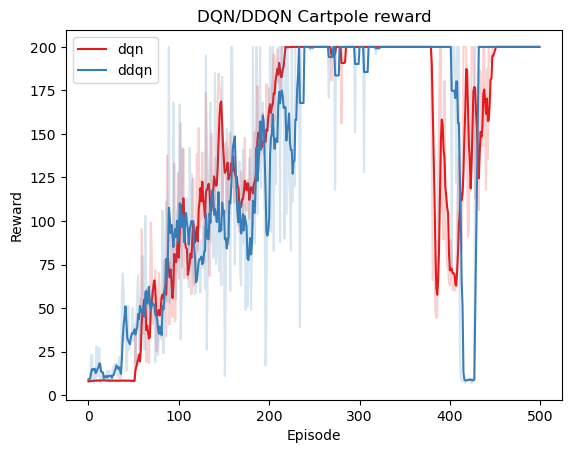

In [12]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ddqn/b8_compare_reward_history.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ddqn/b8_compare_reward_ddqn.npy")]

names = ["dqn", "ddqn"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward, c=colors[i], alpha=0.2)
    plt.plot(smooth(reward, 5), c=colors[i], label=names[i])
plt.title("DQN/DDQN Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

## Lunar Lander

In [ ]:
env = gym.make("LunarLander-v2")
policy = Policy(env.observation_space.shape[0], env.action_space.n, device=DEVICE)
agent = DoubleQLearningAgent(env, policy, tau=0.0005, device=DEVICE)
history = agent.learn(n_episodes=500, batch_size=64, epsilon=0.3, print_every=10)

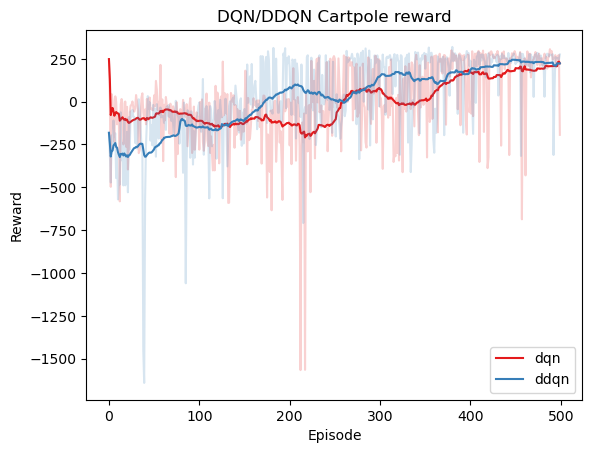

In [15]:
rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ddqn/dqn_lunar_lander_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ddqn/ddqn_lunar_lander_reward.npy")]

names = ["dqn", "ddqn"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward, c=colors[i], alpha=0.2)
    plt.plot(smooth(reward, 40), c=colors[i], label=names[i])
plt.title("DQN/DDQN Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()